In [1]:
import healpy as hp
from pysm3 import units as u
import pysm3
import numpy as np
import matplotlib.pyplot as plt
import toml
from pathlib import Path

In [2]:
from astropy.table import QTable

In [3]:
cd ..

/mnt/home/azonca/p/software/s4mapbasedsims/202308_panexp_spt3g


In [4]:
config = toml.load("common.toml")

In [5]:
config["output_folder"] = "output/{tag}"

In [6]:
# chs = chs[chs["telescope"]=="SAT"]

In [7]:
from astropy.io import fits

In [8]:
import mapsims

In [9]:
chs = mapsims.parse_channels(instrument_parameters=config["instrument_parameters"])

## Verify radio galaxies

In order to verify the Radio Galaxy maps, we take the brightest source (at the lowest frequencies) and check that the flux in Jy is similar to what is in the catalog.
I have separately gone through all the input maps and extracted the flux and saved it in a csv file.
Then I do a simple aperture photometry calculation to integrate the flux across the whole beam and compare it with the expected flux.

In [10]:
clon, clat, glon, glat = (32.86660645897463,
 -50.554023687565746,
 275.28891668590967,
 -62.06147137885603)

In [11]:
import pandas as pd

In [12]:
ref_flux = pd.read_csv("verification/reference_source_flux.csv", index_col=0)

Channel 95ghz radio_rg1 - Flux 45.77 Jy Ref flux 42.27 Jy Ratio 8.29%
Channel 150ghz radio_rg1 - Flux 20.82 Jy Ref flux 18.54 Jy Ratio 12.30%
Channel 220ghz radio_rg1 - Flux 11.69 Jy Ref flux 10.47 Jy Ratio 11.62%


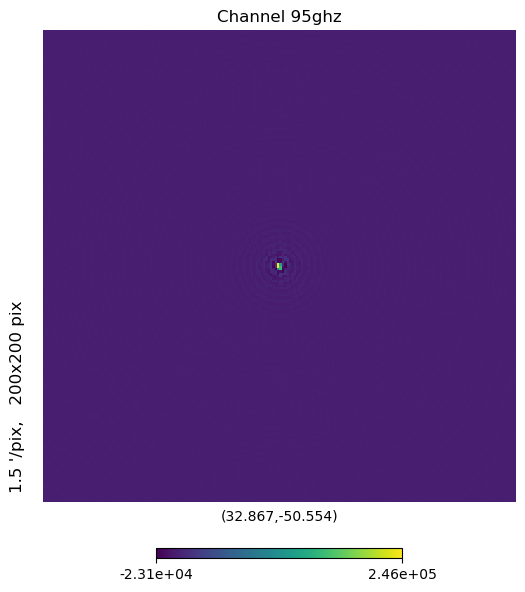

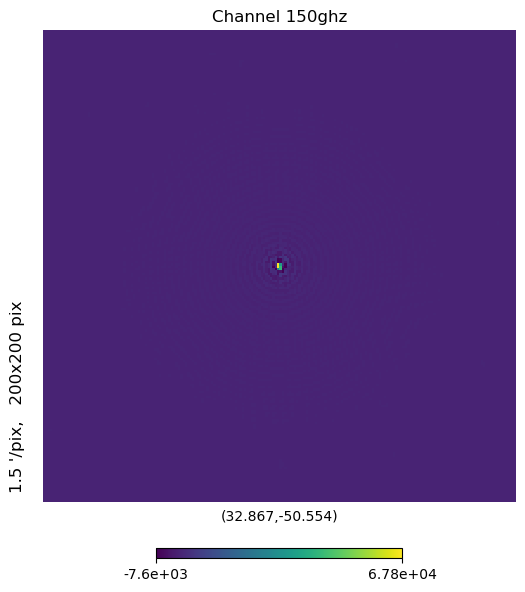

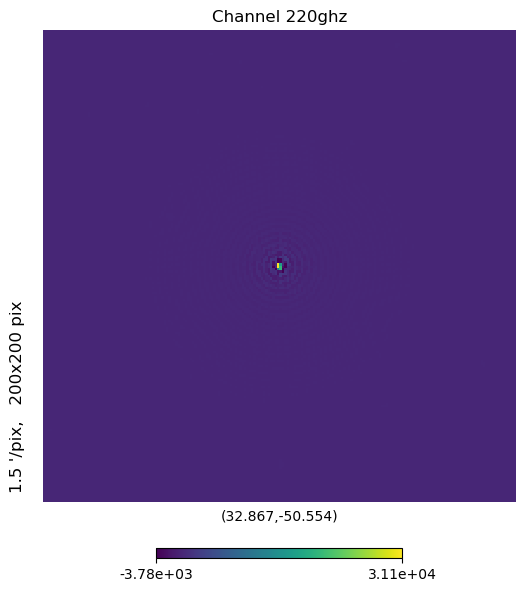

In [13]:
for ch in chs:
    for model in ["radio_rg1"]:
        print(ch, model, end=" - ")
        tag = model
        folder = Path(config["output_folder"].format(tag=tag))
        filename = config["output_filename_template"].format(tag=tag, telescope=ch.telescope, nside=2048, band=ch.band)
        m = hp.read_map(folder / filename) * u.uK_CMB
        nside = hp.npix2nside(len(m))
        vec = hp.ang2vec(clon, clat, lonlat=True)
        disc_ipix = hp.query_disc(nside, vec, ch.beam.to_value(u.radian)*2)
        flux = m[disc_ipix].sum().to(u.Jy/u.sr, equivalencies=u.cmb_equivalencies(ch.center_frequency)) * (hp.nside2pixarea(nside) * u.sr)
        rflux = np.interp(ch.center_frequency.value, np.array(ref_flux.index), ref_flux.values.flatten())*u.Jy
        fractional_error = flux/rflux - 1
        print(f"Flux {flux:.2f} Ref flux {rflux:.2f} Ratio {fractional_error:.2%}")
        assert np.abs(fractional_error) < .3
        hp.gnomview(m, rot=(clon, clat), title=ch)